In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import anndata
from anndata import read_h5ad
import warnings
import time
warnings.filterwarnings("ignore")
import torch
import math
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class simdatset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = torch.from_numpy(self.X[index]).float().to(device)
        y = torch.from_numpy(self.Y[index]).float().to(device)
        return x, y

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.name = 'ae'
        self.inputdim = input_dim
        self.outputdim = output_dim
        self.encoder = nn.Sequential(nn.Dropout(),
                                     nn.Linear(self.inputdim,512),
                                     nn.CELU(),
                                     nn.Dropout(),
                                     nn.Linear(512,256),
                                     nn.CELU(),
                                     nn.Dropout(),
                                     nn.Linear(256,128),
                                     nn.CELU(),
                                     nn.Dropout(),
                                     nn.Linear(128,64),
                                     nn.CELU(),
                                     nn.Linear(64,output_dim),
                                     nn.Hardtanh(0,1)
                                     )
        
        self.decoder = nn.Sequential(nn.Linear(self.outputdim,64,bias=False),
                                     nn.Linear(64,128,bias=False),
                                     nn.Linear(128,256,bias=False),
                                     nn.Linear(256,512,bias=False),
                                     nn.Linear(512,self.inputdim,bias=False))
        
                                               
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,z):
        return self.decoder(z)

    def sigmatrix(self):
        w0 = self.decoder[0].weight.T
        w1 = self.decoder[1].weight.T
        w2 = self.decoder[2].weight.T
        w3 = self.decoder[3].weight.T
        w4 = self.decoder[4].weight.T
        w01 = torch.mm(w0,w1)
        w02 = torch.mm(w01,w2)
        w03 = torch.mm(w02,w3)
        w04 = torch.mm(w03, w4)
        return F.hardtanh(w04,0,1)

    def forward(self, x):
        sigmatrix = self.sigmatrix()
        z = self.encode(x)
        x_recon = torch.mm(z,sigmatrix)
        return x_recon, z, sigmatrix



def train(model, train_loader, optimizer, epochs=10):
    model.train()
    loss = []
    recon_loss = []
    for i in tqdm(range(epochs)):
        for k, (data, label) in enumerate(train_loader):
            optimizer.zero_grad()
            x_recon, cell_prop, sigm = model(data)
            batch_loss = F.l1_loss(cell_prop, label)+F.l1_loss(x_recon,data)
            batch_loss.backward()
            optimizer.step()
            loss.append(F.l1_loss(cell_prop, label).cpu().detach().numpy())
            recon_loss.append(F.l1_loss(x_recon, data).cpu().detach().numpy())

    return model, loss, recon_loss



def predict(model, data):
    model.eval()
    data = torch.from_numpy(data).float().to(device)
    _, pred, sigmatrix = model(data)
    pred = pred.cpu().detach().numpy()
    sigmatrix = sigmatrix.cpu().detach().numpy()
    return pred, sigmatrix


def RMSEscore(pred, true):
    return np.mean(np.abs(pred - true))


def CCCscore(y_pred, y_true):
    # pred: shape{n sample, m cell}
    ccc_value = 0
    for i in range(y_pred.shape[1]):
        r = np.corrcoef(y_pred[:, i], y_true[:, i])[0, 1]
        # print(r)
        # Mean
        mean_true = np.mean(y_true[:, i])
        mean_pred = np.mean(y_pred[:, i])
        # Variance
        var_true = np.var(y_true[:, i])
        var_pred = np.var(y_pred[:, i])
        # Standard deviation
        sd_true = np.std(y_true[:, i])
        sd_pred = np.std(y_pred[:, i])
        # Calculate CCC
        numerator = 2 * r * sd_true * sd_pred
        denominator = var_true + var_pred + (mean_true - mean_pred) ** 2
        ccc = numerator / denominator
        # print(ccc)
        ccc_value += ccc
    return ccc_value / y_pred.shape[1]

def score(pred, label):
    distance = []
    ccc = []
    new_pred = pred.reshape(-1,1)
    new_label = label.reshape(-1,1)
    distance.append(RMSEscore(new_pred, new_label))
    ccc.append(CCCscore(new_pred, new_label))
    print(distance[0], ccc[0])
    return distance[0], ccc[0]

def showloss(loss):
    plt.figure()
    plt.plot(loss)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.show()
            
def reproducibility(seed=1):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
def test_AE_function(train_x,train_y,test_x,test_y,batch_size=128):
    reproducibility(seed=0)
    train_loader = DataLoader(simdatset(train_x, train_y), batch_size=batch_size, shuffle=True)
    model = AutoEncoder(train_x.shape[1], train_y.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
    model, loss, reconloss = train(model, train_loader, optimizer, epochs=int(5000/(len(train_x)/batch_size)))
    showloss(loss)
    showloss(reconloss)
    pred, train_sigm = predict(model, test_x)
    #showloss(loss)
    l1, ccc = score(pred,test_y)
    #l1, ccc = score(test_pred,test_y)
    return l1, ccc
def test_scaden_function(train_x,train_y,test_x,test_y,batch_size=128):
    reproducibility(seed=0)
    architectures = {'m256': ([256,128,64,32],[0,0,0,0]),
                     'm512': ([512,256,128,64],[0, 0.3, 0.2, 0.1]),
                     'm1024': ([1024, 512, 256, 128],[0, 0.6, 0.3, 0.1])}
    model = scaden(architectures, train_x, train_y, epochs=int(5000/(len(train_x)/batch_size)))
    st = time.time()
    model.train()
    pred = model.predict(test_x)
    ed = time.time()
    l1, ccc = score(pred,test_y)
    return l1, ccc

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_units, dropout_rates):
        super().__init__()
        self.hidden_units = hidden_units
        self.dropout_rates = dropout_rates
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.model = self._mlp()

    def forward(self,x):
        # x: (n sample, m gene)
        # output: (n sample, k cell proportions)
        return self.model(x)

    def _mlp(self):
        mlp = nn.Sequential(nn.Linear(self.input_dim,self.hidden_units[0]),
                            nn.Dropout(self.dropout_rates[0]),
                            nn.ReLU(),
                            nn.Linear(self.hidden_units[0], self.hidden_units[1]),
                            nn.Dropout(self.dropout_rates[1]),
                            nn.ReLU(),
                            nn.Linear(self.hidden_units[1], self.hidden_units[2]),
                            nn.Dropout(self.dropout_rates[2]),
                            nn.ReLU(),
                            nn.Linear(self.hidden_units[2], self.hidden_units[3]),
                            nn.Dropout(self.dropout_rates[3]),
                            nn.ReLU(),
                            nn.Linear(self.hidden_units[3], self.output_dim),
                            nn.Softmax(dim=1)
                            )
        return mlp
def initialize_weight(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data,0)
class scaden():
    def __init__(self, architectures, train_x, train_y, lr=1e-4, batch_size=128, epochs=20):
        self.architectures = architectures
        self.model512 = None
        self.model256 = None
        self.model1024 = None
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.inputdim = train_x.shape[1]
        self.outputdim = train_y.shape[1]
        self.train_loader = DataLoader(simdatset(train_x, train_y), batch_size=batch_size, shuffle=True)


    def _subtrain(self, model, optimizer):
        model.train()
        i = 0
        loss = []
        for i in tqdm(range(self.epochs)):
            for data, label in self.train_loader:
                optimizer.zero_grad()
                batch_loss = F.l1_loss(model(data), label)
                batch_loss.backward()
                optimizer.step()
                loss.append(batch_loss.cpu().detach().numpy())
        return model, loss
    
    def showloss(self, loss):
        plt.figure()
        plt.plot(loss)
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.show()
        
    def train(self, mode='all'):
        if mode=='all':
            ##### train
            self.build_model()
            optimizer = torch.optim.Adam(self.model256.parameters(), lr=self.lr, eps=1e-07)
            print('train model256 now')
            self.model256, loss = self._subtrain(self.model256, optimizer)
            #self.showloss(loss)
            optimizer = torch.optim.Adam(self.model512.parameters(), lr=self.lr, eps=1e-07)
            print('train model512 now')
            self.model512, loss = self._subtrain(self.model512, optimizer)
            #self.showloss(loss)
            optimizer = torch.optim.Adam(self.model1024.parameters(), lr=self.lr, eps=1e-07)
            print('train model1024 now')
            self.model1024, loss = self._subtrain(self.model1024, optimizer)
            #self.showloss(loss)



    def build_model(self,mode='all'):
        if mode=='all':
            self.model256 = MLP(self.inputdim, self.outputdim, self.architectures['m256'][0], self.architectures['m256'][1])
            self.model512 = MLP(self.inputdim, self.outputdim, self.architectures['m512'][0], self.architectures['m512'][1])
            self.model1024 = MLP(self.inputdim, self.outputdim, self.architectures['m1024'][0],self.architectures['m1024'][1])
            self.model1024 = self.model1024.to(device)
            self.model512 = self.model512.to(device)
            self.model256 = self.model256.to(device)
            self.model256.apply(initialize_weight)
            self.model512.apply(initialize_weight)
            self.model1024.apply(initialize_weight)
            
    def predict(self, test_x, mode='all'):
        test_x = torch.from_numpy(test_x).to(device).float()
        if mode == 'all':
            self.model256.eval()
            self.model512.eval()
            self.model1024.eval()
        if mode == 'all':
            pred = (self.model256(test_x) + self.model512(test_x) + self.model1024(test_x)) / 3
        return pred.cpu().detach().numpy()


In [4]:
trainingset = ['Liver','Kidney','Lung','Skin','Thymus']
tissue = 'thymus'
training_data = read_h5ad("../mouse_atlas/Tabular Muris/Thymus.h5ad")
data = pd.DataFrame(training_data.X,columns=training_data.var.index)
label = training_data.obs
label.index = range(len(label))
data.index = range(len(data))

In [5]:
# 5-fold train_test_split
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5,shuffle=True,random_state=0).split(data,label)

In [6]:
# for k, (trainindex, testindex) in enumerate(kfold):
#     print(k)
#     reproducibility(seed=0)
#     train_x = data.loc[trainindex].values
#     train_y = label.loc[trainindex].values
    
#     test_x = data.loc[testindex]
#     genename = test_x.columns
#     test_x = test_x.values
#     test_y = label.loc[testindex]
#     noise = np.random.normal(test_x.mean(axis=0),test_x.std(axis=0),size=test_x.shape)
#     test_x = test_x + np.abs(1e-2*noise)

#     for i in range(test_x.shape[0]):
#         indices = np.random.choice(np.arange(test_x.shape[1]), replace=False, size=int(test_x.shape[1] * 0.2))
#         test_x[i,indices] = 0 
    
#     test_x = pd.DataFrame(test_x,columns=genename)
#     test_x.T.to_csv("csx/"+tissue+"_"+str(k)+"_noise_csx.txt",sep='\t')
#     test_x.to_csv("rnasieve/"+tissue+"_"+str(k)+"_noise_rs.csv")
#     #test_y.to_csv("groundtruth/"+tissue+"_"+str(k)+"_fractions.csv")

0


100%|██████████| 200/200 [00:56<00:00,  3.54it/s]


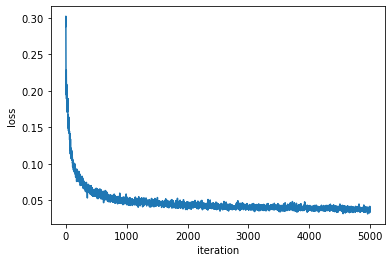

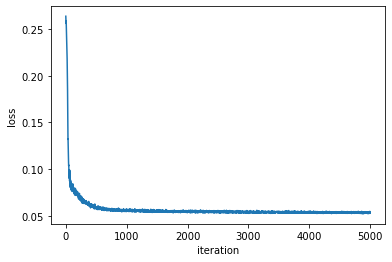

0.043156190155614234 0.9479060423833698
0.043156190155614234 0.9479060423833698
1


100%|██████████| 200/200 [00:56<00:00,  3.56it/s]


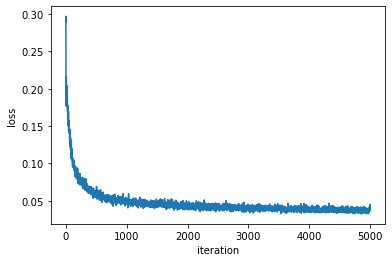

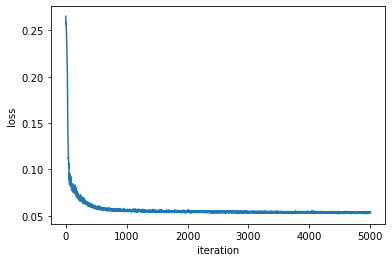

0.039543698657855585 0.9573680828784894
0.039543698657855585 0.9573680828784894
2


100%|██████████| 200/200 [00:55<00:00,  3.59it/s]


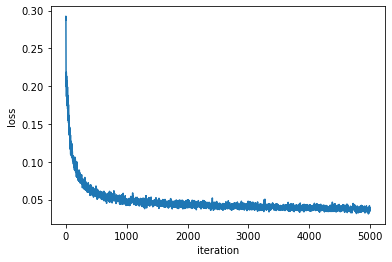

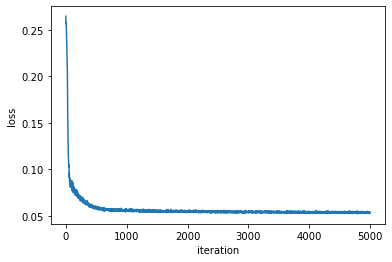

0.03552952621453193 0.9658276495807274
0.03552952621453193 0.9658276495807274
3


100%|██████████| 200/200 [00:56<00:00,  3.53it/s]


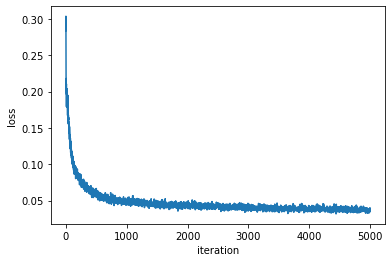

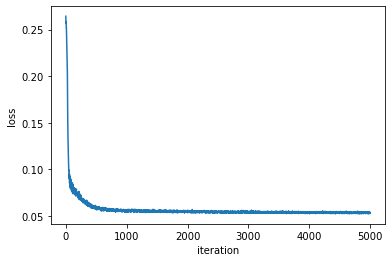

0.039001477780313674 0.9592755939897097
0.039001477780313674 0.9592755939897097
4


100%|██████████| 200/200 [00:55<00:00,  3.59it/s]


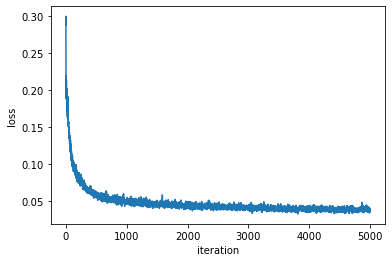

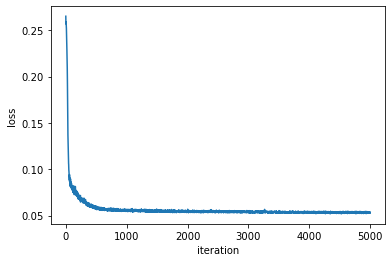

0.03797835561783436 0.9565950003291451
0.03797835561783436 0.9565950003291451
0.03904184968522996 0.9573944738322883


In [7]:
### GAUSSIAN NOISE on test data, guassian distribution along each gene
L1 = []
CCC = []
for k, (trainindex, testindex) in enumerate(kfold):
    print(k)
    reproducibility(seed=0)
    train_x = data.loc[trainindex].values
    train_y = label.loc[trainindex].values

    test_x = data.loc[testindex].values
    test_y = label.loc[testindex].values
    
    noise = np.random.normal(test_x.mean(axis=0),test_x.std(axis=0),size=test_x.shape)
    test_x = test_x + np.abs(1e-2*noise)

    for i in range(test_x.shape[0]):
        indices = np.random.choice(np.arange(test_x.shape[1]), replace=False, size=int(test_x.shape[1] * 0.2))
        test_x[i,indices] = 0 
    
    train_x = np.log2(train_x + 1)
    test_x = np.log2(test_x + 1)
    mms = MinMaxScaler()
    test_x = mms.fit_transform(test_x.T)
    test_x = test_x.T
    train_x = mms.fit_transform(train_x.T)
    train_x = train_x.T
    
    a, b = test_AE_function(train_x,train_y,test_x,test_y)
    print(a,b)
    L1.append(a)
    CCC.append(b)
    
print(sum(L1)/len(L1),sum(CCC)/len(CCC))

In [8]:
# sample-wise gaussian noise
# use 20% dropout

In [9]:
# AE with noise
# kidney 0.025821186108983308 0.949692368018454
# liver 0.021139011414448173 0.9660086380540628
# lung 0.019001137088528266 0.8627325056164004
# skin 0.029307696042318455 0.9333488527347853
# thymus 0.03904184968522996 0.9573944738322883

In [10]:
# scaden with noise
# thymus 0.0478086862010355 0.9279420801423391
# skin 0.031087418246519893 0.9204024241306639
# lung 0.028904249837975033 0.6260784087148654
# liver 0.028581994969314222 0.9319975334542505
# kidney 0.03054704209210123 0.9209235104781615
